# Syracuse Real Estate Investment Trust
### Investment Opportunity Zip Codes Prediction
Syracuse Applied Data Science, IST-718 Big Data Analytics  

Ryan Timbrook (RTIMBROO)  
DATE  
ASSIGNMENT: Lab 2  



## Research question:  
Can we predict which three zip codes provide the best investment opportunity for the Syracuce Real EState Investment Trust (RSEIT)?  

* Using the base data available from [Zillow](files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv)
    * Review the data - clean as appropriate
    * Provide an intial data analysis to include:
        * Develop time series plots for the following Arkansas metro areas:
            * **Hot Springs**, **Little Rock**, **Fayetteville**, **Searcy**
            * Present all values from **1997 to present**
            * **Average** at the **metro area level**
    * Using data from Zillow:
        * Develop model(s) for forecasting **average median housing value by zip code** for **2018**
        * Use the historical data from **1997 to 2017 as the training data**
        * Integrate data from other sources (like; Bureau of Labor Statistics and Census data) to imrove upon the base model(s)
    * Answer the following questions:
        * What technique/algorithm/decisions process did you use to down sample?
        * What three zip codes provide the best investment opportunity for the SREIT?
        * Why?
    * Bonus: Develop a geographic visualiztion that best depicts the data and recommendations:
        * By state
        * Median housing for Dec (state average)
 ------------------------------------------------------------------------------------------------------------------------------

### Coding Environment Setup
Import packages

In [1]:
# standard data science packages
import pandas as pd
import numpy as np
import warnings

from scipy.stats import uniform #for training and test splits
from scipy.stats import gaussian_kde as kde # for resampling dataset
from scipy import stats #
import statsmodels.formula.api as smf #R-like model specification

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt # 2D plotting
%matplotlib inline
plt.style.use('fivethirtyeight')

import timeit # for performance debugging
import logging

In [2]:
# custome python packages
import rtimbroo_utils as ru


Another alternative for building time series models at scale.  Based on the research from facebook - [Prophet](https://research.fb.com/prophet-forecasting-at-scale/) - allows the user to quickly produce high quality forecasts with the ability to adjust multiple parameters.
Initial code modeled after Digital Ocean's [tutorial](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3).  
**Data Tranansformations:**
Prophet requires columns to be in certain formats
Use python transpose  

*[Prophet Quick Start Guide:](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

In [3]:
# timeseries packages
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


#### Workspace Config


In [4]:
# configure the workspace
dataDir = './data/'
configDir = './config/'
modelBaselineDir = './models/baseline/'
modelImprovedDir = './models/improved/'
imageDir = './images/'
#loggerConfig = 'loggerConfig.yaml'
loglevel = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

In [5]:
# get a logger for troubleshooting / data exploration
warnings.filterwarnings('ignore')
logger = ru.getLogger(loglevel)

10


In [6]:
# set globals
zillowDataFile = 'Zip_Zhvi_SingleFamilyResidence.csv'


### OBTAIN the Zillow Residential data
* Using the base data available from [Zillow](files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv)

Zillow Home Value Index (ZHVI): A smoothed, seassonally adjusted measure of the median estimated home value across a given region and housing type. It is a dollar-denominated [alternative to repeat-sales indices](https://wp.zillowstatic.com/3/ZHVI-InfoSheet-04ed2b.pdf).

* Review the data - clean as appropriate
* Provide an intial data analysis to include:
    * Develop time series plots for the following Arkansas metro areas:
        * **Hot Springs**, **Little Rock**, **Fayetteville**, **Searcy**
            * Metro Names:
                * Fayetteville-Springdale-Rogers
                * Hot Springs
                * Little Rock-North Little Rock-Conway
                * Searcy
        * Present **all values from 1997 to present**
        * **Average** at the **metro area level**
* Using data from Zillow:
    * Develop model(s) for forecasting **average median housing value by zip code** for **2018**
    * Use the historical data from **1997 to 2017 as the training data**

In [7]:
# read in datasets
#zillow = pd.read_csv(dataDir+zillowDataFile, error_bad_lines=False, encoding = "ISO-8859-1", delimiter=' *, *')
zillow = pd.read_csv(dataDir+zillowDataFile, error_bad_lines=False, encoding = "ISO-8859-1")

#if logger.debug: print(zillow.head())
zillow.shape

(15605, 286)

In [8]:
# look over the zillow dataset
if logger.debug: print((str(zillow.shape)))
if logger.debug: print((zillow.values))
#if logger.debug: print((zillow.describe()))

cnts = ru.getNaNCount(zillow)
if logger.debug: print((cnts))

if logger.level == 20: # 10-DEBUG, 20-INFO, 30-WARNING
    ru.findColumnsNaN(zillow,rowIndex=False)

if logger.debug: print(len(zillow.RegionName.unique()))
zillow.RegionName.dtype

(15605, 286)
[[84654 60657 'Chicago' ... 1080400 1082300 1072200]
 [91982 77494 'Katy' ... 333500 333400 332300]
 [84616 60614 'Chicago' ... 1347400 1345200 1334500]
 ...
 [75672 40404 'Berea' ... 143000 141100 140500]
 [93733 81225 'Mount Crested Butte' ... 807200 806500 804800]
 [95851 89155 'Mesquite' ... 376800 376400 376000]]
(188570, 2304)
15605


dtype('int64')

### SCRUB / CLEAN
Clean and perform initial transformations steps of the data

Subset Zillow on the AR 'Metro' regions for initial time series investigation and plotting.   
Zillow Dataset on these primary metro areas, 1997 to present:  
Note: 61 observations, some observations don't have complete date records.
* Metro Names:  
    * 'Fayetteville-Springdale-Rogers'
        * RegionID:89749 | Records start on: 2003-07
        * RegionID:89717 | Records start on: 2014-07
    * 'Hot Springs'  
    * 'Little Rock-North Little Rock-Conway'  
    * 'Searcy'
        * RegionID:89370 | Records start on: 2012-01  
        
**Zipcode = RegionName**

In [9]:
# remove columns dates prior to 1997
pre1997Cols = ['1996-04','1996-05','1996-06','1996-07','1996-08','1996-09','1996-10','1996-11','1996-12']

zillow = zillow.drop(columns=pre1997Cols)
if logger.debug: print(zillow.shape)
    
# remove any possible white space in column values
sCols = ['City','State','Metro','CountyName']
for a in sCols:
    zillow[a] = zillow[a].str.strip()

(15605, 277)


In [10]:
# Rename RegionName to ZipCode for clarity
zillow = zillow.rename(index=str, columns={'RegionName':'ZipCode'})

#zillow.head()
zillow.ZipCode = zillow.ZipCode.astype(str)

# keep a copy for now
zillow_v1 = zillow.copy()

#zillow.head()
zillow.ZipCode = zillow.ZipCode.astype(str)

# create integer id mapping to zipcode for future lookups
id_to_zipcode = {i:z for i,z in enumerate(zillow.ZipCode)}
zipcode_to_id = {z:i for i,z in enumerate(zillow.ZipCode)}

In [11]:
# AR metro areas
# Hot Springs, Little Rock, Fayetteville, Searcy
# Create Timeseries plots of the average home prices by metro area

# Metro Areas
fayetteVille = 'Fayetteville-Springdale-Rogers'
hotSprings = 'Hot Springs'
lrNorth_lrConway = 'Little Rock-North Little Rock-Conway'
searcy = 'Searcy'

# subset the zillow dataset to the AR metro areas
ar_fayetteVille = zillow[(zillow.State=='AR') & (zillow.Metro==fayetteVille)]
if logger.debug: print('Fayetteville-Springdale-Rogers: shape {0}'.format(ar_fayetteVille.shape))
#if logger.debug: print('Fayetteville-Springdale-Rogers: ZipCodes \n{0}\n'.format(ar_fayetteVille.ZipCode.sort_values()))

ar_hotSprings = zillow[(zillow.State=='AR') & (zillow.Metro==hotSprings)]
if logger.debug: print('Hot Springs: shape {0}'.format(ar_hotSprings.shape))
#if logger.debug: print('Hot Springs: ZipCodes \n{0}\n'.format(ar_hotSprings.ZipCode.sort_values()))

ar_littleRock = zillow[(zillow.State=='AR') & (zillow.Metro==lrNorth_lrConway)]
if logger.debug: print('Little Rock-North Little Rock-Conway: shape {0}'.format(ar_littleRock.shape))
# logger.debug: print('Little Rock-North Little Rock-Conway: ZipCodes \n{0}\n'.format(ar_littleRock.ZipCode.sort_values()))

ar_searcy = zillow[(zillow.State=='AR') & (zillow.Metro==searcy)]
if logger.debug: print('Searcy: shape {0}'.format(ar_searcy.shape))
#if logger.debug: print('Searcy: ZipCodes \n{0}\n'.format(ar_searcy.ZipCode.sort_values()))

#print(ar_fayetteVille.head())

Fayetteville-Springdale-Rogers: shape (21, 277)
Hot Springs: shape (4, 277)
Little Rock-North Little Rock-Conway: shape (30, 277)
Searcy: shape (6, 277)


The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [12]:
# Facebook Prophet requires columns to be in a specific format
def dfTransformForProphet(df,cols,index):
    try:
        df = df.drop(columns=cols)
    except KeyError:
        pass
    df = df.set_index(index)
    df = df.T
    df.index = pd.to_datetime(df.index)
    return (df)
#------------------------------------------------
#------------------------------------------------
# function to format and create a prophet model
def beProphet(label,components,modelOutDir,predPeriods=12):
    import pickle
    model={}
    # restructure the dataframe to fit prophet
    df = pd.DataFrame(components)
    df = df.reset_index()
    logValue = 'log_'+label
    df[logValue] = np.log(df[label])
    dfProphet = df.rename(index=str, columns={logValue:'y','index':'ds'})
    dfProphet = dfProphet.loc[:,['y','ds']]
    
    # get prices annual delta
    
    
    # setting uncertainty interval to 95%
    zipModel = Prophet(interval_width=0.95)
    zipModel_fit = zipModel.fit(dfProphet)
    model['model_fit'] = zipModel_fit
    # make future dates dataframe
    future_dates = zipModel.make_future_dataframe(periods=predPeriods, freq='M', include_history=True)
    
    # model
    forecast = zipModel.predict(future_dates)
    model['model_forecast'] = forecast
    
    # predicted versus actual
    
    
    #save model to file
    with open(modelOutDir+'_fit','wb') as f:
        pickle.dump(zipModel_fit,f)
    
    with open(modelOutDir+'_forecast','wb') as f:
        pickle.dump(forecast,f)
    
    return(model)
#---------------------------------------------
#---------------------------------------------
# util function for getting the Date series values
def getDateColumns(series,d):   
    return([i for i in series if d in i])
#---------------------------------------------
#---------------------------------------------
# Calculate the yearly price changes
def calcPriceDelta(df,dateSeries):
    years = [str(i) for i in range(1997,2020)]
    dateCols = {}
    for y in years:
        dateCols[y] = getDateColumns(dateSeries,y)
    
    yearAvg = {}
    for d in dateCols:
        subSet = df[dateSeries.isin(dateCols[d])]
        anualAvg = subSet.iloc[:,1].mean()
        yearAvg[d] = anualAvg
        #break
    #print('Yearly Price Averages: {0}\n'.format(yearAvg))

    thisYear = ''
    priorYear = ''
    prior_years = []
    priceDelta = {}
    priceDeltaPercent = {}
    for i, year in enumerate(yearAvg):
        thisYear = year
        
        if not i == 0:
            priorYear = prior_years[i-1] # not first year
        else:
            priorYear = year # is first year
        #print('This Year: {0}'.format(thisYear))
        #print('Prior Year: {0}\n'.format(priorYear))
        
        # set prior year list
        prior_years.append(thisYear)
    
        # calculate delta between years
        #print('This Year Average Price: {0}'.format(yearAvg[thisYear]))
        #print('Prior Year Average Price: {0}\n'.format(yearAvg[priorYear]))
        
        delta = yearAvg[thisYear] - yearAvg[priorYear]
        percentDelta = delta/yearAvg[thisYear]*100
        
        #print('This Year: {0}, Prior Year: {1}, Price Delta: {2}\n'.format(thisYear,priorYear,delta))
        
        priceDelta[thisYear] = delta
        priceDeltaPercent[thisYear] = percentDelta
    #print('Yearly Price Change:{0}\n'.format(priceDelta))
    return(pd.DataFrame([yearAvg,priceDelta,priceDeltaPercent], index=['Yearly_Price_Avg','Yearly_Price_Delta',
                                                                       'Yearly_Price_Delta_Percent']))

#---------------------------------------------
#---------------------------------------------


In [13]:
# build AR metro dataframe for initial analysis
dropCols = ['RegionID','City','State','Metro','CountyName','SizeRank']
ar_fay = dfTransformForProphet(ar_fayetteVille,dropCols,'ZipCode')
ar_hs = dfTransformForProphet(ar_hotSprings,dropCols,'ZipCode')
ar_lr = dfTransformForProphet(ar_littleRock,dropCols,'ZipCode')
ar_s = dfTransformForProphet(ar_searcy,dropCols,'ZipCode')

ar_fay['FayetteVille_AvgHomePrice'] = round(ar_fay.mean(axis=1),2)
ar_hs['HotSprings_AvgHomePrice'] = round(ar_hs.mean(axis=1),2)
ar_lr['LittleRock_AvgHomePrice'] = round(ar_lr.mean(axis=1),2)
ar_s['Searcy_AvgHomePrice'] = round(ar_s.mean(axis=1),2)

ar_fay_avgs = ar_fay.loc[:,['FayetteVille_AvgHomePrice']]
ar_metros = pd.DataFrame(ar_fay_avgs)

ar_hs_avgs = ar_hs.loc[:,['HotSprings_AvgHomePrice']]
ar_lr_avgs = ar_lr.loc[:,['LittleRock_AvgHomePrice']]
ar_s_avgs = ar_s.loc[:,['Searcy_AvgHomePrice']]

# join the metro areas to one dataframe
ar_metros = ar_metros.join([ar_hs_avgs,ar_lr_avgs,ar_s_avgs])

In [14]:
ar_metros.head()

ZipCode,FayetteVille_AvgHomePrice,HotSprings_AvgHomePrice,LittleRock_AvgHomePrice,Searcy_AvgHomePrice
1997-01-01,82552.63,72150.0,85206.67,62180.0
1997-02-01,83236.84,72300.0,85733.33,62440.0
1997-03-01,83921.05,72400.0,86260.00,62680.0
1997-04-01,84557.89,72550.0,86823.33,62960.0
1997-05-01,85031.58,72825.0,87356.67,63220.0


In [15]:
# calculate annual price average and delta change from prior year
regionPriceDeltas = {}
ypd1 = pd.DataFrame()
for i, metro in enumerate(ar_metros.columns):
    m_i = ar_metros.loc[:,metro]
    m_i = m_i.reset_index()
    m_i = m_i.rename(index=str,columns={'index':'Date'})
    m_i.Date = m_i.Date.astype(str)
    ypd = calcPriceDelta(m_i,m_i.Date)
    ypd = ypd.T
    ypd = ypd.reset_index()
    ypd = ypd.rename(index=str,columns={'index':'Date'})
    ypd = ypd.rename(index=str,columns={'Yearly_Price_Avg':metro+'_Avg',
                                        'Yearly_Price_Delta':metro+'_Delta',
                                       'Yearly_Price_Delta_Percent':metro+'_Delta_Percent'})
    #print(ypd.head())   
    
    ypd1['Date'] = ypd['Date']
    ypd1[metro+'_Avg'] = ypd[metro+'_Avg']
    ypd1[metro+'_Delta'] = ypd[metro+'_Delta']
    ypd1[metro+'_Delta_Percent'] = ypd[metro+'_Delta_Percent']
        
    #break
#print(ypd1.head())

In [16]:
#regionPriceDeltas
metroD = ['Date','FayetteVille_AvgHomePrice_Delta','HotSprings_AvgHomePrice_Delta',
          'LittleRock_AvgHomePrice_Delta','Searcy_AvgHomePrice_Delta']
dPrice = ypd1.loc[:,metroD]
dPrice.tail()

,Date,FayetteVille_AvgHomePrice_Delta,HotSprings_AvgHomePrice_Delta,LittleRock_AvgHomePrice_Delta,Searcy_AvgHomePrice_Delta
18,2015,6375.317500,2114.583333,2886.665000,113.889167
19,2016,9934.127500,4350.000000,5505.000833,1731.945833
20,2017,13343.650833,6447.916667,7664.445833,2758.331667
21,2018,12990.872500,3660.416667,4445.555000,5063.889167
22,2019,10511.508333,4866.666667,3869.166667,6355.556667


In [17]:
#region price percent delta
metroPD = ['Date','FayetteVille_AvgHomePrice_Delta_Percent','HotSprings_AvgHomePrice_Delta_Percent',
          'LittleRock_AvgHomePrice_Delta_Percent','Searcy_AvgHomePrice_Delta_Percent']
dpPrice = ypd1.loc[:,metroPD]
dpPrice.tail()

,Date,FayetteVille_AvgHomePrice_Delta_Percent,HotSprings_AvgHomePrice_Delta_Percent,LittleRock_AvgHomePrice_Delta_Percent,Searcy_AvgHomePrice_Delta_Percent
18,2015,4.535364,1.633566,1.984845,0.124452
19,2016,6.600610,3.251222,3.647138,1.857425
20,2017,8.143979,4.597650,4.832420,2.873179
21,2018,7.346212,2.543649,2.726493,5.010444
22,2019,5.610650,3.271251,2.317984,5.916426


In [225]:
#pd.melt(dPrice,['Date'])

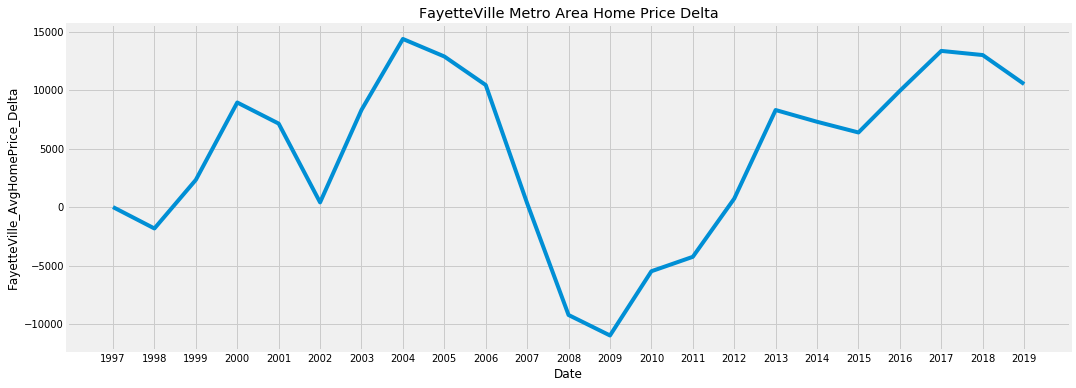

In [18]:
plt.figure(figsize=(16,6))
sns.lineplot(x='Date',y='FayetteVille_AvgHomePrice_Delta',
            data=dPrice);

plt.title('FayetteVille Metro Area Home Price Delta')
plt.show()

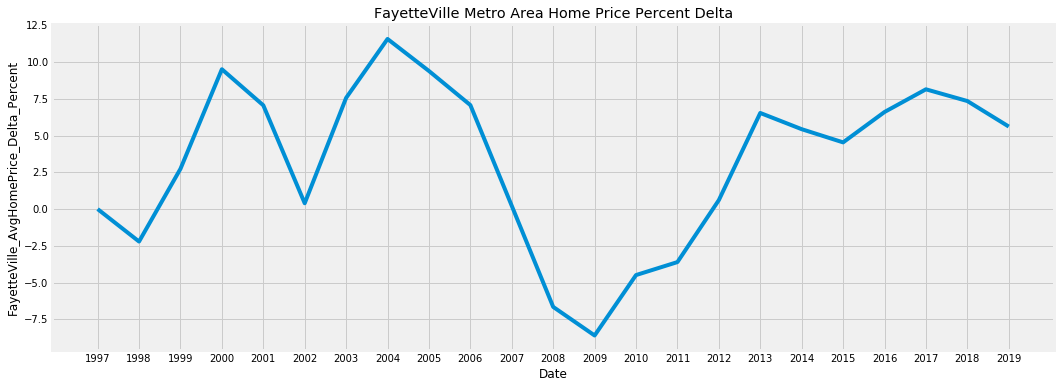

In [19]:
plt.figure(figsize=(16,6))
sns.lineplot(x='Date',y='FayetteVille_AvgHomePrice_Delta_Percent',
            data=dpPrice);

plt.title('FayetteVille Metro Area Home Price Percent Delta')
plt.show()

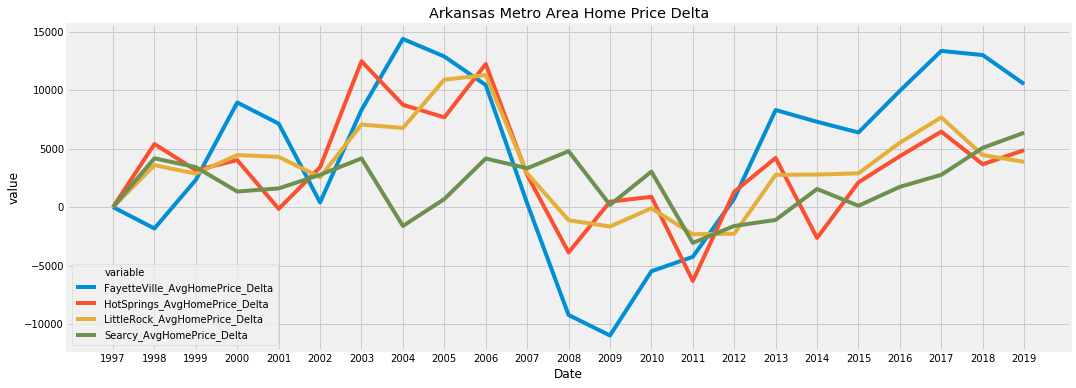

In [20]:
# plot 
plt.figure(figsize=(16,6))
sns.lineplot(x='Date',y='value',hue='variable',
            data=pd.melt(dPrice,['Date']));

plt.title('Arkansas Metro Area Home Price Delta')
plt.show()

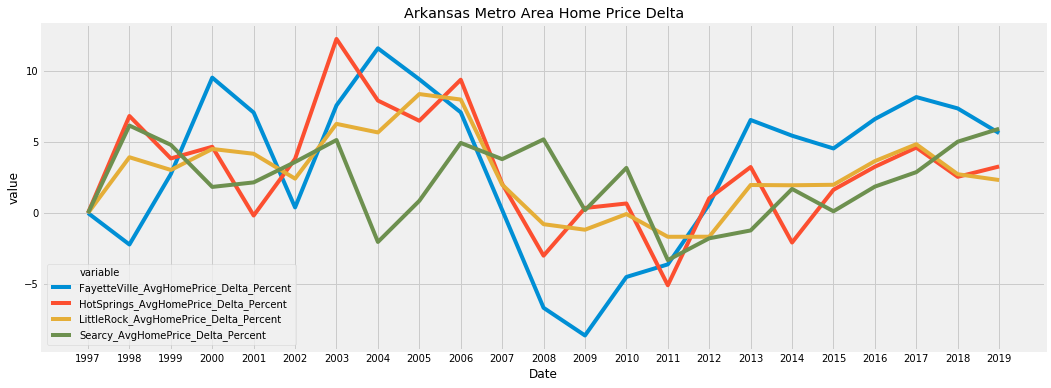

In [21]:
# plot 
plt.figure(figsize=(16,6))
sns.lineplot(x='Date',y='value',hue='variable',
            data=pd.melt(dpPrice,['Date']));

plt.title('Arkansas Metro Area Home Price Delta')
plt.show()

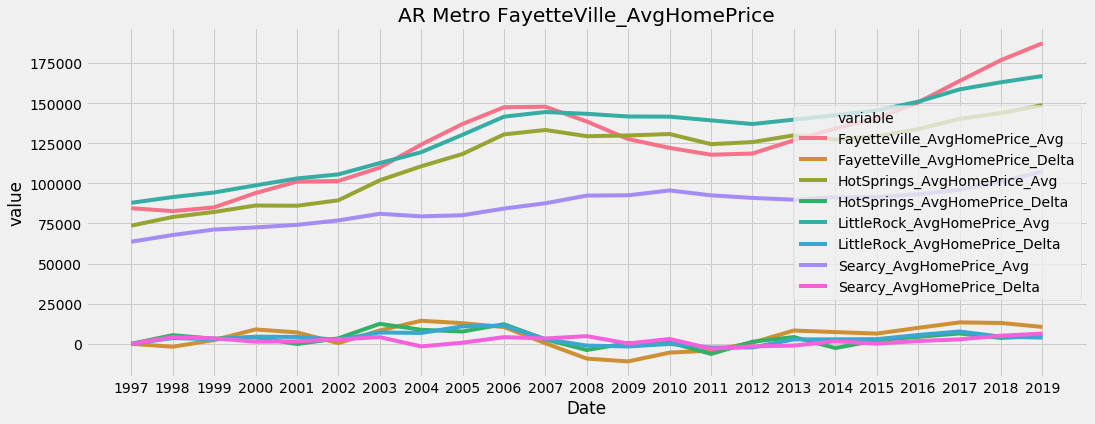

In [261]:
plt.figure(figsize=(16,6))
sns.lineplot(x='Date',y='value',hue='variable',
            data=pd.melt(ypd1,['Date']));

plt.title('Arkansas Metro Area Home Price')
plt.show()

### EXPLORE
Provide an intial data analysis to include:
* Develop time series plots for the following Arkansas metro areas:
    * Hot Springs, Little Rock, Fayetteville, Searcy
    * Present all values from 1997 to present
    * Average at the metro area level

### Descriptive Statistics - Arkansa Metro Areas

In [22]:
# descriptive statistics
print('FayetteVille_AvgHomePrice Stats: \n{0}\n'.format(ar_metros.FayetteVille_AvgHomePrice.describe()))
print('HotSprings_AvgHomePrice Stats: \n{0}\n'.format(ar_metros.HotSprings_AvgHomePrice.describe()))
print('LittleRock_AvgHomePrice Stats: \n{0}\n'.format(ar_metros.LittleRock_AvgHomePrice.describe()))
print('Searcy_AvgHomePrice Stats: \n{0}\n'.format(ar_metros.Searcy_AvgHomePrice.describe()))

FayetteVille_AvgHomePrice Stats: 
count       270.000000
mean     125629.047333
std       26780.873237
min       81878.950000
25%      102230.260000
50%      125547.500000
75%      142832.500000
max      188995.240000
Name: FayetteVille_AvgHomePrice, dtype: float64

HotSprings_AvgHomePrice Stats: 
count       270.000000
mean     116036.481481
std       22265.684348
min       72150.000000
25%       90106.250000
50%      126250.000000
75%      131612.500000
max      149075.000000
Name: HotSprings_AvgHomePrice, dtype: float64

LittleRock_AvgHomePrice Stats: 
count       270.000000
mean     129622.271704
std       22889.048391
min       85206.670000
25%      106229.165000
50%      139551.670000
75%      144176.670000
max      167096.670000
Name: LittleRock_AvgHomePrice, dtype: float64

Searcy_AvgHomePrice Stats: 
count       270.000000
mean      85328.345704
std       10560.427209
min       62180.000000
25%       77475.000000
50%       89486.665000
75%       92545.000000
max      107816.67

### Time Series Plots - Arkansas Metro Areas
Python packages:
* fbprophet import Prophet

In [29]:
# build time series models
# perform exploratory data analysis techiques
# Build prophet timeseries models for the metro area, save to dictionary object
metroModels = {}
for metro, avgprice in ar_metros.items():
    model = beProphet(metro,avgprice,modelBaselineDir+metro,predPeriods=6)
    metroModels[metro]=model


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


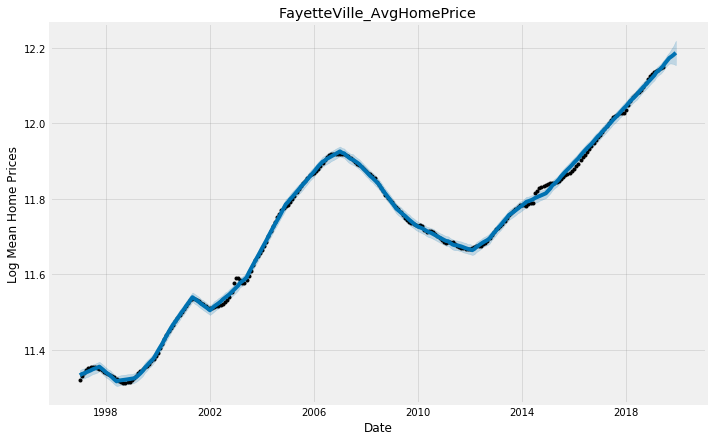

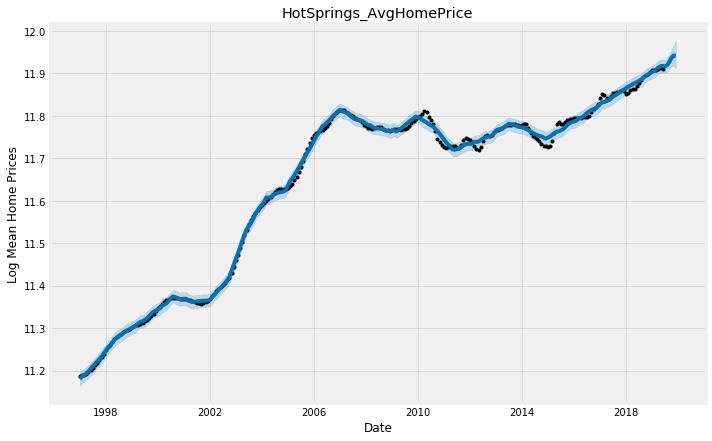

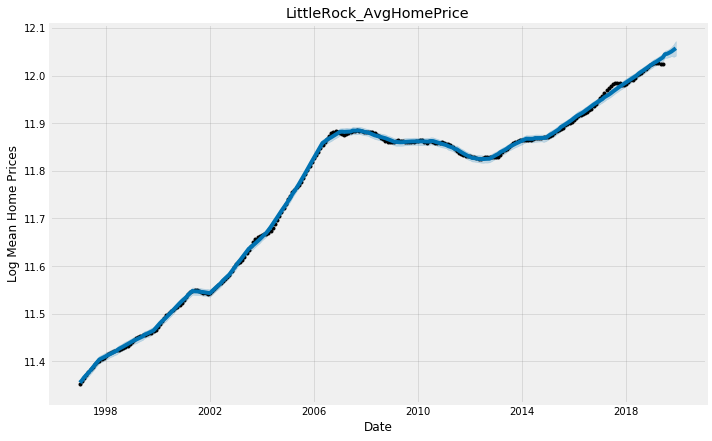

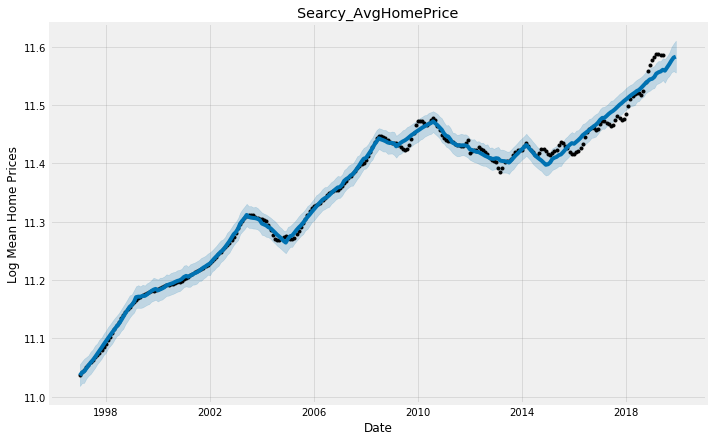

In [30]:
# time series plots
#plot Metro Area Timeseries Models that were created above
metroModelKeys = ['FayetteVille_AvgHomePrice','HotSprings_AvgHomePrice','LittleRock_AvgHomePrice','Searcy_AvgHomePrice']
metroPlots = []
for region in metroModelKeys:
    m_fit = metroModels[region]['model_fit']
    m_fit_forecast = metroModels[region]['model_forecast']
    p_fit = m_fit.plot(m_fit_forecast,uncertainty=True)
    ax = p_fit.get_axes()
    ax[0].set_title(region)
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Log Mean Home Prices')
    metroPlots.append(ax)
    plt.savefig(imageDir+region+'_fit_plot.png')
    #plt.show()
    #break
#plt.show()

In [37]:
# reading model in from file and plotting
import pickle
metroModelKeys = ['FayetteVille_AvgHomePrice','HotSprings_AvgHomePrice','LittleRock_AvgHomePrice','Searcy_AvgHomePrice']
fitFile = modelBaselineDir+'Searcy_AvgHomePrice'+'_fit'
forecastFile = modelBaselineDir+'Searcy_AvgHomePrice'+'_forecast'
with open(fitFile,'rb') as f:
    m_fit = pickle.load(f)
with open(forecastFile,'rb') as f:
    m_forecast = pickle.load(f)

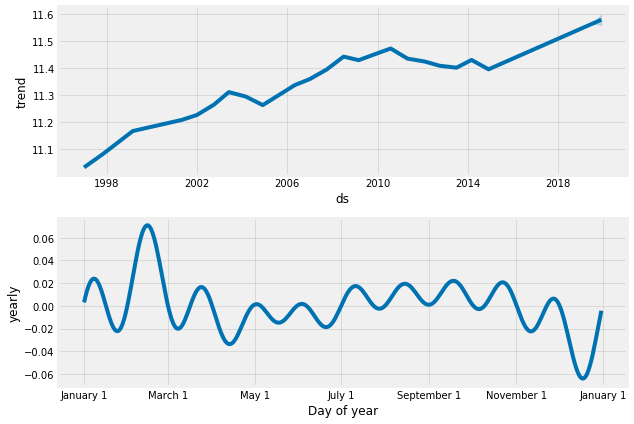

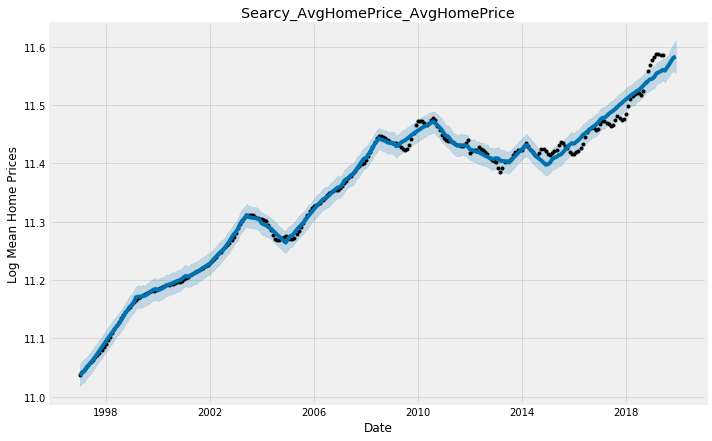

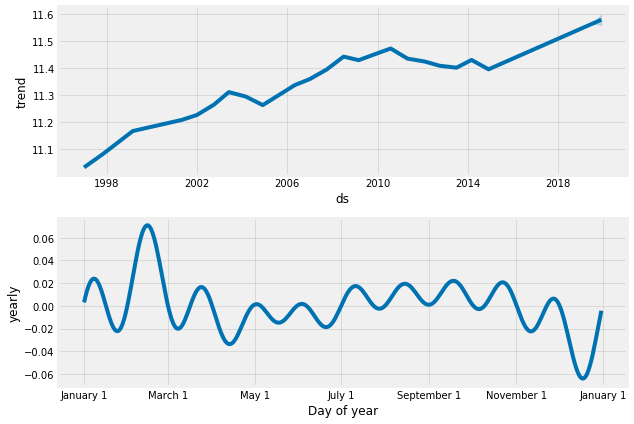

In [38]:
# plot
p_fit = m_fit.plot(m_forecast,uncertainty=True)
ax = p_fit.get_axes()
ax[0].set_title('Searcy_AvgHomePrice_AvgHomePrice')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Log Mean Home Prices')

m_fit.plot_components(m_forecast)

## MODEL
### Develop model(s) for forecasting *average median housing value* by *zip code* for *2018*  
* Use the historical data from 1997 through 2017 as the training data  
* Integrate data from other sources, like the *Bureau of Labor Statistics and Census data* to improve upon the base model(s)  
    * Capital markets and economics: **using time series analysis**
        * Seasonal unemployment, Price/return series, Risk analysis

**The model should answer these questions:**  
* What technique/algorithm/decision process was used to down sample?  
* What three zip codes provide the best investment opportunity for the SREIT? And Why?  

**Modeling Algorithms and Python packages used:**  
* Algorithm: 
    * Time series:
    * Picking:
        * selecting zip codes - tip: **w4 lessons**
    * Classification:
        * python package: **'surprise'**

**Problem Types:**  
* Picking/Choosing  
* 

**Simple Approach**
* Subset the data
* Model for 1 zip code, then apply to the rest...
* Tips: 
    * look at **code from w6** - use **'recommend'**
    * look at code from w6 - iteration through list/file
    * look at code from w6, breakouts - help with selecting/classification/recommendation

**Percent change of housing value --- PCHV**  

In [39]:
zillow.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1997-01,1997-02,1997-03,...,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,344900.0,346200.0,347000.0,...,1047600,1049400,1048800,1049900,1054300,1059400,1067800,1080400,1082300,1072200
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,197300.0,195400.0,193000.0,...,338100,336700,336100,336200,335500,334200,333500,333500,333400,332300
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,503200.0,501900.0,499500.0,...,1319100,1317900,1319800,1324200,1330000,1336400,1342000,1347400,1345200,1334500
3,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,96600.0,96400.0,96200.0,...,178500,179400,180300,181100,182100,183300,183000,181800,181800,182800
4,93144,79936,El Paso,TX,El Paso,El Paso County,5,77800.0,77900.0,77900.0,...,125700,126400,126900,127600,128200,128600,128900,128700,128500,128800


In [40]:
# segment the zipcode data for model processing
# 1: cut zipcode down 1997-2017 - as training data set
# remove columns dates prior to 1997
post2017Cols = ['2018-01','2018-02','2018-03','2018-04','2018-05','2018-06',
                '2018-07','2018-08','2018-09','2018-10','2018-11','2018-12',
                '2019-01','2019-02','2019-03','2019-04','2019-05','2019-06']

validate2018Cols = ['2018-01','2018-02','2018-03','2018-04','2018-05','2018-06',
                '2018-07','2018-08','2018-09','2018-10','2018-11','2018-12']
dropCols = ['RegionID','City','Metro','CountyName','SizeRank']

evalDropCols = dropCols+['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06']
zillow_eval = zillow.drop(columns=evalDropCols)
zillow_train = zillow.drop(columns=post2017Cols+dropCols)
zillow_train = zillow_train.sort_values('State')
           
# 2: segment on just 2018 for prediction validation
keepCols = ['ZipCode','State']+validate2018Cols
zillow_validate = zillow.loc[:,keepCols]
zillow_validate = zillow_validate.sort_values('State')


In [41]:
z_train = dfTransformForProphet(zillow_train,['State'],'ZipCode')
print('Zillow Training Data: Prophet Transposed shape \n{0}\n'.format(z_train.shape))

z_validate2018 = dfTransformForProphet(zillow_validate,['State'],'ZipCode')

print('Zillow 2018 Validation Data: Prophet Transposed shape \n{0}\n'.format(z_validate2018.shape))
z_validate2018.head()

Zillow Training Data: Prophet Transposed shape 
(252, 15605)

Zillow 2018 Validation Data: Prophet Transposed shape 
(12, 15605)



ZipCode,99516,99577,99623,99669,99709,99515,99517,99503,99712,99567,...,82007,82214,82201,82240,82609,82070,82716,82513,82636,82520
2018-01-01,494400,414900,227100,250500,262800,405700,335800,311000,273700,426800,...,177900,145800,192300,153800,236400,224900,225600,227600,214500,225200
2018-02-01,498100,415200,225900,249800,262300,405400,335200,310500,273500,425500,...,179200,146000,193400,155000,237600,225800,222400,229500,217700,227600
2018-03-01,499400,412600,225200,249500,262200,403200,333900,309300,273500,421700,...,180000,145700,193800,156000,237800,226600,218400,231500,220900,229800
2018-04-01,499100,410000,226700,248600,263600,400400,333700,308900,275100,418600,...,181000,147300,195000,157100,238600,228000,216700,233600,223200,231700
2018-05-01,499900,408800,229400,246100,266000,399200,335000,308800,277400,418400,...,183200,152300,196800,159000,240700,230500,216500,235700,225300,234300


In [42]:
zillow_eval = dfTransformForProphet(zillow_eval,['State'],'ZipCode')
zillow_eval.head()

ZipCode,60657,77494,60614,77449,79936,77084,10467,11226,60640,94109,...,84781,12429,97028,12720,97102,1338,3293,40404,81225,89155
1997-01-01,344900.0,197300.0,503200.0,96600.0,77800.0,95800.0,151500.0,168000.0,220100.0,825100.0,...,138700.0,77700.0,136000.0,62100.0,193000.0,91800.0,90600.0,59500.0,204900.0,176500.0
1997-02-01,346200.0,195400.0,501900.0,96400.0,77900.0,95500.0,151600.0,168900.0,221100.0,834600.0,...,139100.0,77900.0,136000.0,62200.0,194400.0,91900.0,90200.0,59900.0,207100.0,176700.0
1997-03-01,347000.0,193000.0,499500.0,96200.0,77900.0,95300.0,151700.0,169700.0,222000.0,843600.0,...,139500.0,78000.0,135700.0,62200.0,195500.0,92200.0,89900.0,60300.0,209100.0,176800.0
1997-04-01,347900.0,191800.0,497500.0,96100.0,77800.0,95100.0,151800.0,170400.0,223100.0,853500.0,...,140000.0,78000.0,135200.0,62300.0,196500.0,92500.0,89700.0,60800.0,211200.0,176800.0
1997-05-01,349100.0,191800.0,495900.0,96200.0,77800.0,95100.0,152000.0,171100.0,224300.0,864000.0,...,140500.0,78100.0,134500.0,62400.0,197500.0,92900.0,89500.0,61300.0,213400.0,176900.0


In [43]:
# Calculate prior five year net value changes
def calcPriorYearNetChange(label,components,dataOutDir):
    years = [str(i) for i in range(2014,2019)]
    #print(years)
    dateCols = {}
    
    # restructure the dataframe
    df = pd.DataFrame(components)
    df = df.reset_index()
    
    prices = df.rename(index=str, columns={label:'Median_Price','index':'Date'})
    prices = prices.loc[:,['Date','Median_Price']]
    prices['Date'] = prices.Date.astype(str)
    
    #filter the Date series to the last five years
    for y in years:
        dateCols[y] = getDateColumns(prices.Date,y)
    
    # get the yearly avg subset
    yearAvg = {}
    for d in dateCols:
        subSet = prices[prices.Date.isin(dateCols[d])]
        anualAvg = subSet.iloc[:,1].mean()
        yearAvg[d] = anualAvg
        #break
    #print('Yearly Price Averages: {0}\n'.format(yearAvg))
    
    deltas = calcYearlyDelta(yearAvg)
    #print(deltas[1])
    
    # deltas[0] is the price delta, deltas[1] is the the percent delta
    priorAvgPercentDeltas = {}
    priorYearPercentAvg = 0.0
    prior2YearPercentAvg = 0.0
    prior3YearPercentAvg = 0.0
    prior4YearPercentAvg = 0.0
    prior5YearPercentAvg = 0.0
    sortedDeltaKeys = reversed(sorted(deltas[1].keys()))
    for i, key in enumerate(sortedDeltaKeys):
        if i == 0: 
            priorYearPercentAvg = deltas[1][key];
            priorAvgPercentDeltas['OneYearAvg'] = priorYearPercentAvg
        if i == 1: 
            #print(deltas[1][key])
            #print(np.mean([priorYearPercentAvg,deltas[1][key]]))
            prior2YearPercentAvg = np.mean([priorYearPercentAvg,deltas[1][key]])
            priorAvgPercentDeltas['TwoYearAvg'] = prior2YearPercentAvg
        if i == 2: 
            #print(deltas[1][key])
            #print(np.mean([priorYearPercentAvg,prior2YearPercentAvg,deltas[1][key]]))
            prior3YearPercentAvg = np.mean([priorYearPercentAvg,prior2YearPercentAvg,deltas[1][key]])
            priorAvgPercentDeltas['ThreeYearAvg'] = prior3YearPercentAvg
        if i == 3: 
            #print(deltas[1][key])
            #print(np.mean([priorYearPercentAvg,prior2YearPercentAvg,prior3YearPercentAvg,deltas[1][key]]))
            prior4YearPercentAvg = np.mean([priorYearPercentAvg,prior2YearPercentAvg,prior3YearPercentAvg,deltas[1][key]])
            priorAvgPercentDeltas['FourYearAvg'] = prior4YearPercentAvg
        if i == 4: 
            #print(deltas[1][key])
            #print(np.mean([priorYearPercentAvg,prior2YearPercentAvg,prior3YearPercentAvg,prior4YearPercentAvg,deltas[1][key]]))
            prior5YearPercentAvg = np.mean([priorYearPercentAvg,prior2YearPercentAvg,prior3YearPercentAvg,prior4YearPercentAvg,deltas[1][key]])
            priorAvgPercentDeltas['FiveYearAvg'] = prior5YearPercentAvg
     
    return(priorAvgPercentDeltas)
#--------------------------------------------    
#--------------------------------------------    

# Calculate yearly deltas
def calcYearlyDelta(yearlyAvgPrices):
    thisYear = ''
    priorYear = ''
    prior_years = []
    priceDelta = {}
    priceDeltaPercent = {}
    for i, year in enumerate(yearlyAvgPrices):
        thisYear = year
        
        if not i == 0:
            priorYear = prior_years[i-1] # not first year
        else:
            priorYear = year # is first year
        #print('This Year: {0}'.format(thisYear))
        #print('Prior Year: {0}\n'.format(priorYear))
        
        # set prior year list
        prior_years.append(thisYear)
    
        # calculate delta between years
        #print('This Year Average Price: {0}'.format(yearAvg[thisYear]))
        #print('Prior Year Average Price: {0}\n'.format(yearAvg[priorYear]))
        
        delta = yearlyAvgPrices[thisYear] - yearlyAvgPrices[priorYear]
        percentDelta = delta/yearlyAvgPrices[thisYear]*100
        
        #print('This Year: {0}, Prior Year: {1}, Price Delta: {2}\n'.format(thisYear,priorYear,delta))
        
        priceDelta[thisYear] = delta
        priceDeltaPercent[thisYear] = percentDelta
    #print('Yearly Price Change:{0}\n'.format(priceDelta))
    return(priceDelta,priceDeltaPercent)



In [44]:
# create a dataset to evaluate zipcode price performance
zipCodeAvgDelta_5 = {}
i = 0
for zipcode, price in zillow_eval.items():
    zipCodeAvgDelta_5[zipcode] = calcPriorYearNetChange(zipcode,price,dataDir)
    #i = i+1
    #if i > 4: break
#print(zipCodeAvgDelta_5)
    
delta5 = pd.DataFrame(zipCodeAvgDelta_5)
delta5 = delta5.T
delta5 = delta5.reset_index()
delta5 = delta5.rename(index=str, columns={'index':'ZipCode'})
cols = ['ZipCode','OneYearAvg','TwoYearAvg','ThreeYearAvg','FourYearAvg','FiveYearAvg']
delta5 = delta5[cols]
delta5.head()
delta5.to_csv(dataDir+'zipcode_fiveyear_avg_price_percent.csv')

In [46]:

delta5.shape
delta5.head()
delta5Top10_fiveYearAvg = delta5.sort_values('FiveYearAvg', ascending=False).head(10)
delta5Top10_fiveYearAvg
delta5Top10_oneYearAvg = delta5.sort_values('OneYearAvg', ascending=False).head(10)
#delta5Top10_oneYearAvg

In [47]:
delta5Top10_fiveYearAvg

,ZipCode,OneYearAvg,TwoYearAvg,ThreeYearAvg,FourYearAvg,FiveYearAvg
2643,30315,33.053245,29.848357,26.043715,21.801677,22.149399
866,30032,28.471072,22.467730,23.055558,24.644119,19.727696
4297,29405,27.446025,26.511627,19.336513,19.442008,18.547235
4536,33805,22.389435,23.205006,19.139119,20.336521,17.014016
6969,34785,27.272727,22.323290,18.771192,16.418539,16.957150
3450,7050,28.118209,21.207066,16.696146,17.540963,16.712477
5097,33714,20.922128,21.233407,19.921016,19.579158,16.331142
1281,18102,24.529305,22.053236,17.361840,16.023187,15.993514
9478,30288,24.226681,20.019458,18.553583,16.721854,15.904315
10352,29661,24.605137,22.048447,17.972283,14.320429,15.789259


In [377]:
# perform ZipCod model creation and validation techniques
# build time series models
# perform exploratory data analysis techiques
# Build prophet timeseries models for the metro area, save to dictionary object
#zipCodeModels = {}
#for zipcode, price in z_train.items():
    #model = beProphet(zipcode,price,modelBaselineDir+zipcode,predPeriods=13)
    #zipCodeModels[zipcode_to_id[zipcode]]=model


In [86]:
#validate zipcode id mappings
#zipcode_to_id['99516']
#id_to_zipcode[6350]

'99516'

In [48]:
# test plot
#imageDir
def plotFit(zipcode, fit,forecast,title,imageDir=imageDir):
    plt.figure(figsize=(20,15))
    p_fit = fit.plot(forecast,uncertainty=True)
    ax = p_fit.get_axes()
    ax[0].set_title(title, fontsize="15", color="black", horizontalalignment='center', verticalalignment='top')
    ax[0].set_xlabel('ZipCode: '+zipcode+' | '+'Date')
    ax[0].set_ylabel('Log Mean Home Prices')
   
    plt.savefig(imageDir+title+'_fit_plot.png')
    plt.show()
    
    
    pc_fit = fit.plot_components(forecast)
    ax = pc_fit.get_axes()
    ax[0].set_title(title)
    ax[0].set_xlabel('ZipCode: '+zipcode+' | '+'Date')
    #ax[0].set_ylabel('Log Mean Home Prices')
    #plt.figure(figsize=(16,6))
    plt.savefig(imageDir+title+'_fit_component_plot.png')
    plt.show()

<Figure size 1440x1080 with 0 Axes>

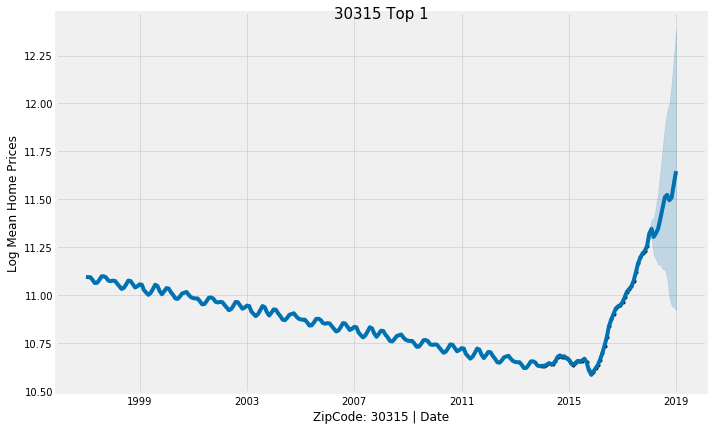

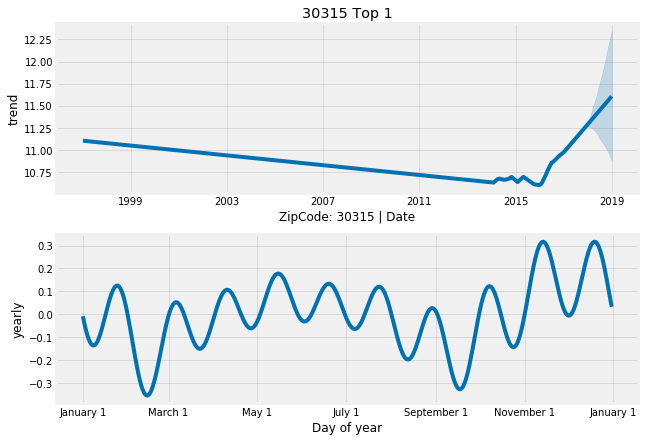

<Figure size 1440x1080 with 0 Axes>

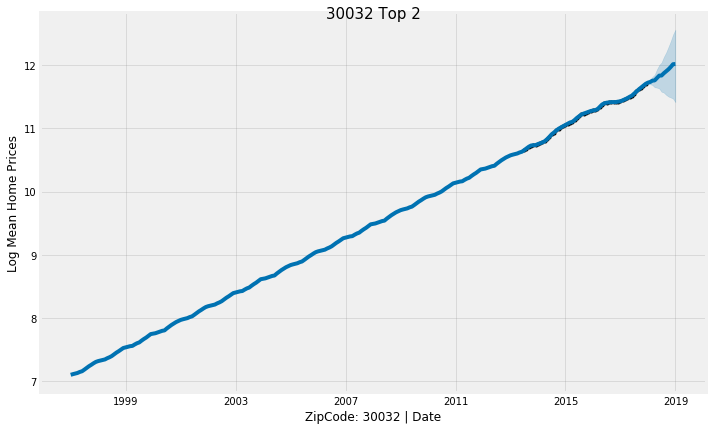

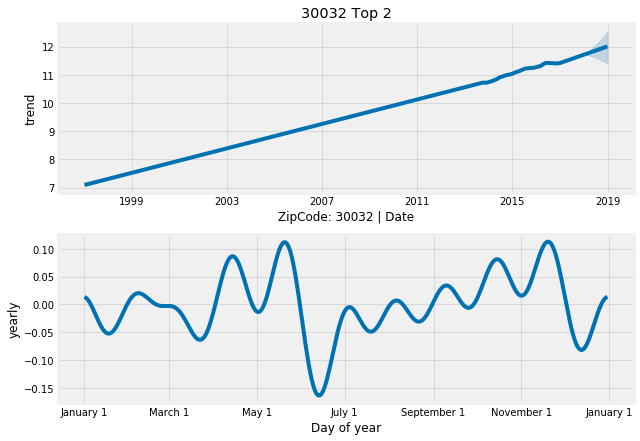

<Figure size 1440x1080 with 0 Axes>

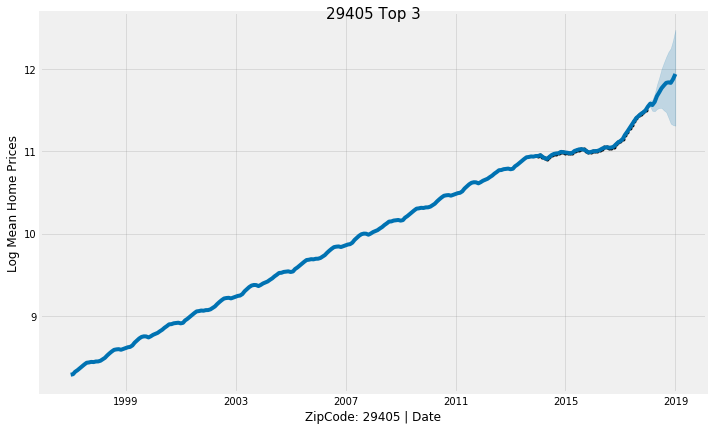

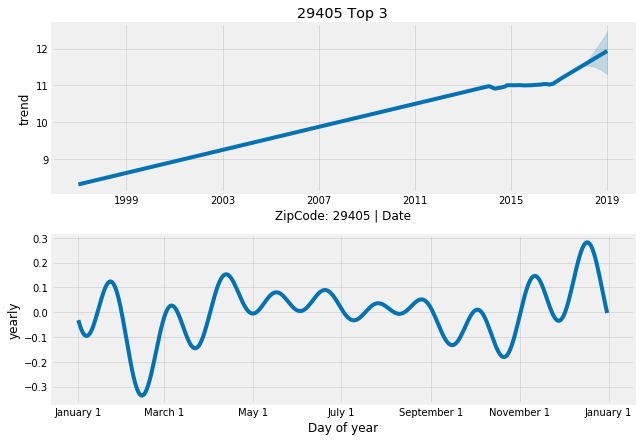

<Figure size 1440x1080 with 0 Axes>

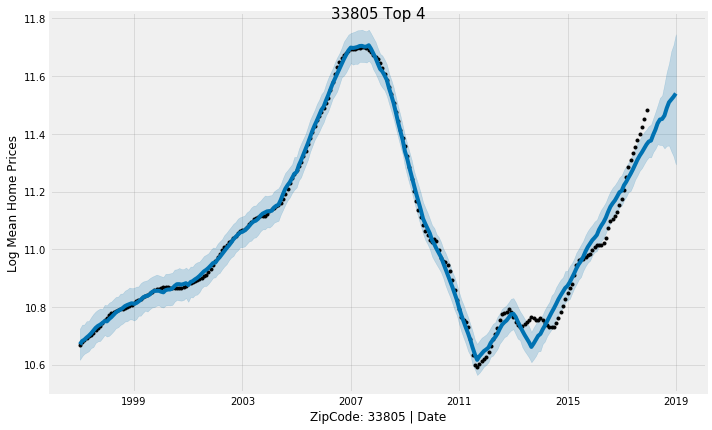

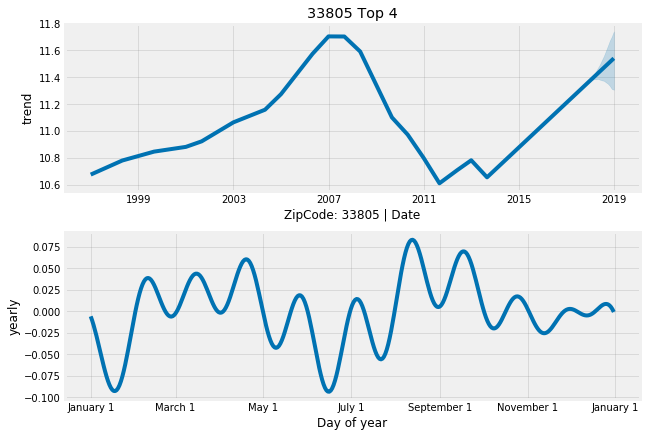

<Figure size 1440x1080 with 0 Axes>

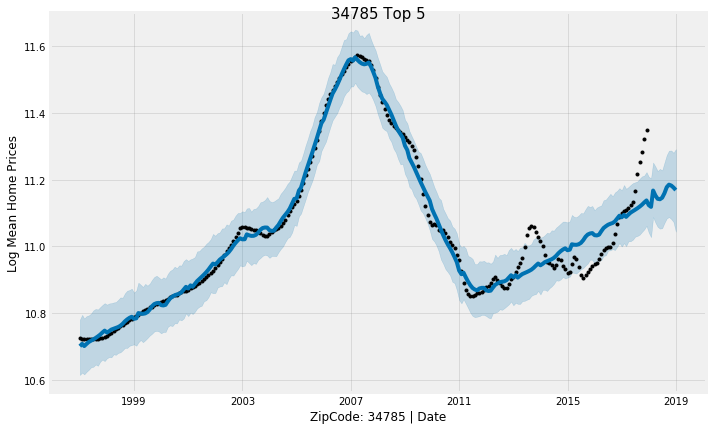

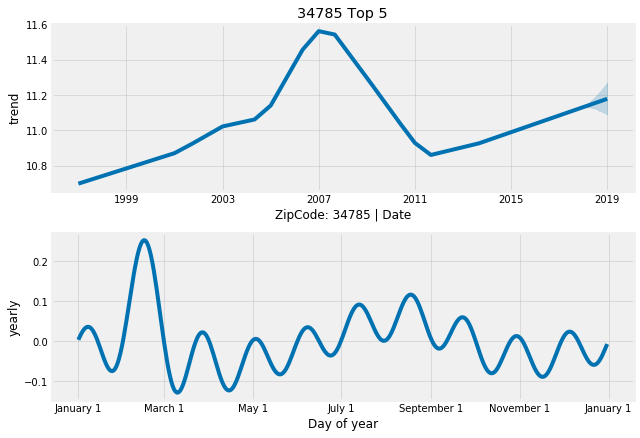

In [50]:
# test reading model in from file and plotting
import pickle

#first look at subset of the modeled zipcodes - top 10, 5 year value percent change (2018,2017,2016,2015,2014)
i = 0
t10 = 10
for z in delta5Top10_fiveYearAvg.ZipCode:
    #print(z)
    fitFile = modelBaselineDir+z+'_fit'
    forecastFile = modelBaselineDir+z+'_forecast'
    m_fit = None
    m_forecast = None
    with open(fitFile,'rb') as f:
        m_fit = pickle.load(f)
    with open(forecastFile,'rb') as f:
        m_forecast = pickle.load(f)
    
    plotFit(z,m_fit,m_forecast,z+' Top '+str(i+1), 'Five Year Home Value Delta')
    
    i = i+1
    if i >= 5: break
    

#### Model Validation
Perform model validations

### INTERPRET
Interpret the model results, make knowledge based recommendations

In [ ]:
# perform interpretation steps

### Bonus Section:
Bonus: Develop a geographic visualiztion that best depicts the data and recommendations:
* By state
* Median housing for Dec (state average)